In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import pylab
import glob, os
import scipy.stats as stats
from scipy.stats import gaussian_kde
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import chi2
from sklearn.metrics import r2_score
import timeit
%matplotlib inline

In [2]:
# Format to remove scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# options of samples

In [3]:
df_train = pd.read_csv(r'R:/Angela/fast_trips/internal dataset/SF_90_df_train.csv')
df_test = pd.read_csv(r'R:/Angela/fast_trips/internal dataset/SF_90_df_test.csv')

how much is the record? 

In [4]:
print len(df_train)+len(df_test)

266817


2012 Fall data

In [5]:
Spring_Fall_Sample = pd.read_csv(r'R:/Angela/fast_trips/SampleDataSpringFall_4day.csv')

In [7]:
np.unique(Spring_Fall_Sample[Spring_Fall_Sample['mo']==9]['day'])

array([20], dtype=int64)

In [8]:
Spring_Fall_Sample.columns

Index([u'Unnamed: 0', u'Unnamed: 0.1', u'Unnamed: 0.1', u'stop_sequence',
       u'block', u'route', u'unique_stop_no', u'stop_name', u'arr_hour',
       u'arr_min', u'arr_sec', u'dep_hr', u'dep_min', u'dep_sec', u'on',
       u'off', u'load', u'loadcode', u'mo', u'day', u'yr', u'sched_pattern',
       u'latitude', u'longitude', u'distance', u'door_cycles', u'delta',
       u'trip', u'dow', u'direction', u'delta_miles', u'delta_minutes',
       u'delta_pass_miles', u'delta_pass_hours', u'vehno', u'line_apc',
       u'data_batch', u'sched_time', u'sched_run_time', u'distance_gps',
       u'sched_dev', u'actual_time', u'dwell_time_interval', u'sign_up_date',
       u'gps_qc', u'count_qc', u'assignment_qc', u'rec_type', u'wheelchair',
       u'bikerack', u'import_vers', u'unadj_on', u'unadj_off', u'capacity',
       u'over_cap', u'north_south', u'east_west', u'date_id'],
      dtype='object')

In [9]:
FALL12 = Spring_Fall_Sample[(Spring_Fall_Sample['mo'] == 9) & (Spring_Fall_Sample['day'] == 20)]

In [10]:
len(FALL12)

94460

In [11]:
def data_content(data):
    data = data[['on', 'off', 'vehno', 'stop_name', 'stop_sequence', 'yr', 'mo', 'day', 'arr_hour', 'arr_min', 
                 'arr_sec', 'dep_hr', 'dep_min', 'dep_sec', 'route', 'load', 'date_id']]
    data.columns = ['ON', 'OFF', 'VEHNO', 'ANAME', 'STOPA', 'YR','MO', 'DAY','HR', 'MIN', 'SEC', 'DHR', 'DMIN', 'DSEC', 'ROUTE', 'LOAD', 'date_id']
    
    return data

In [12]:
test = FALL12

In [13]:
test = data_content(test)

In [14]:
test.columns

Index([u'ON', u'OFF', u'VEHNO', u'ANAME', u'STOPA', u'YR', u'MO', u'DAY',
       u'HR', u'MIN', u'SEC', u'DHR', u'DMIN', u'DSEC', u'ROUTE', u'LOAD',
       u'date_id'],
      dtype='object')

In [32]:
test.to_csv(r'R:/Angela/fast_trips/internal dataset/SF_2012_Sep_20th.csv')

# read the new validation day

In [15]:
oneday_fall12 = pd.read_csv(r'R:/Angela/fast_trips/internal dataset/SF_2012_Sep_20th_validation.csv')

# something extra to make sure it perform good

In [16]:
df_train.columns[:60]

Index([u'Unnamed: 0', u'ON', u'OFF', u'VEHNO', u'ANAME', u'STOPA', u'YR',
       u'HR', u'MIN', u'SEC', u'DHR', u'DMIN', u'DSEC', u'ROUTE', u'LOAD',
       u'date_id', u'pre_load', u'COMPUTE_TIMESTOP', u'COMPUTE_DOORCOLSE',
       u'COMPUTE_DOORDWELL', u'Doors', u'Artic', u'Floor', u'capacity',
       u'two_doors', u'three_doors', u'Route Type', u'Express', u'OWL',
       u'Rapid', u'on_threedoors', u'off_threedoors', u'on_floor',
       u'off_floor', u'floor_threedoors', u'floor_twodoors', u'on_express',
       u'off_express', u'on_rapid', u'off_rapid', u'on_owl', u'off_owl',
       u'max_pasg', u'abs_pasg', u'pre_standees', u'pre_crowding', u'friction',
       u'eol', u'vehno_date', u'5446_1', u'5446_2', u'5446_4', u'5446_5',
       u'5446_6', u'5447_1', u'5447_2', u'5447_4', u'5447_5', u'5447_6',
       u'5448_1'],
      dtype='object')

In [17]:
test = df_train

In [18]:
test['on+off'] = test['ON'] + test['OFF']

In [19]:
test2 = test.groupby('on+off')['COMPUTE_DOORDWELL']

In [20]:
test2_df = pd.DataFrame(test2.mean())

In [21]:
test2_df['on+off'] = test2_df.index

C:\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


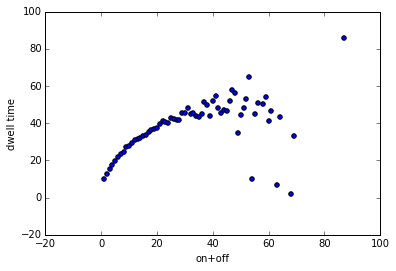

In [22]:
x = test2_df['on+off']
y = test2_df['COMPUTE_DOORDWELL']
plt.scatter(x, y)
plt.xlabel('on+off')
plt.ylabel('dwell time')

In [64]:
#test2_df.to_csv(r'R:/Angela/fast_trips/internal dataset/SF_on+off_dwell_for_plots.csv')

# Build multi-linear regression model

# Model  - without vehicle IDs 

In [23]:
X2_train = df_train[['ON','OFF','Floor','three_doors','Express','OWL',
                     'on_threedoors','off_threedoors','on_floor','off_floor',
                     'on_express','off_express','on_rapid','off_rapid',
                     'on_owl','off_owl', 'friction']]

X2_test = df_test[['ON','OFF','Floor','three_doors','Express','OWL',
                   'on_threedoors','off_threedoors','on_floor','off_floor',
                   'on_express','off_express','on_rapid','off_rapid',
                   'on_owl','off_owl', 'friction']]

y2_train = df_train['COMPUTE_DOORDWELL']
y2_test = df_test['COMPUTE_DOORDWELL']

In [24]:
lm2 = LinearRegression()
lm2.fit(X2_train, y2_train)
pred2_train = lm2.predict(X2_train)
pred2_test = lm2.predict(X2_test)
LinearRegression(copy_X=True, fit_intercept=True,normalize=False)

# Construct a data frame that contains features and estimated coefficients
sklearn_results2 = pd.DataFrame(zip(X2_train.columns, lm2.coef_), columns = ['features', 'estimatedCoefficients'])
# p-values
scores, pvalues = chi2(X2_train, y2_train)
sklearn_results2['pvalues'] = pd.DataFrame(pvalues)
sklearn_results2['scores'] = pd.DataFrame(scores)

In [25]:
print sklearn_results2

          features  estimatedCoefficients  pvalues     scores
0               ON                  2.082    0.000 188285.632
1              OFF                  1.402    0.000  89961.126
2            Floor                 -2.480    0.000   3576.584
3      three_doors                  1.539    0.000   1889.599
4          Express                 -1.089    0.000    377.890
5              OWL                 -1.080    0.000    327.130
6    on_threedoors                 -0.531    0.000  87729.875
7   off_threedoors                 -0.422    0.000  50408.303
8         on_floor                 -0.193    0.000  30864.325
9        off_floor                 -0.191    0.000  13112.981
10      on_express                 -0.279    0.000  10722.390
11     off_express                 -0.250    0.000  10668.446
12        on_rapid                  0.005    0.000  54313.387
13       off_rapid                 -0.088    0.000  33279.599
14          on_owl                  0.585    0.000    439.109
15      

In [49]:
#sklearn_results2.to_csv('R:/Angela/fast_trips/muni_apc_2015/passenger_var_datasets_withoutVeh_6day_absOnOff_03082016.csv')

In [26]:
# R-square
R22 = r2_score(y2_train, pred2_train) 
print R22

0.255168227877


# Correlation table

find the top correlations in a correlation matrix with Pandas

In [51]:
c2 = X2_train.corr().abs()
s2 = c2.unstack()
so2 = s2.order(kind="quicksort")

In [52]:
print len(so2)
soo2 = so2.dropna()
soo2 = soo2[soo2 >= 0.500]
soo2 = soo2[soo2 != 1.0]
print len(soo2)

324
24


In [53]:
soo2

Floor           on_floor         0.504
on_floor        Floor            0.504
Floor           off_floor        0.510
off_floor       Floor            0.510
Express         off_express      0.521
off_express     Express          0.521
three_doors     on_threedoors    0.538
on_threedoors   three_doors      0.538
three_doors     off_threedoors   0.557
off_threedoors  three_doors      0.557
Express         on_express       0.569
on_express      Express          0.569
off_threedoors  OFF              0.570
OFF             off_threedoors   0.570
ON              on_threedoors    0.574
on_threedoors   ON               0.574
OWL             off_owl          0.598
off_owl         OWL              0.598
Rapid           on_rapid         0.616
on_rapid        Rapid            0.616
off_rapid       Rapid            0.633
Rapid           off_rapid        0.633
on_owl          OWL              0.640
OWL             on_owl           0.640
dtype: float64

# Validation Plots with 2012 Fall day

In [40]:
X3_test = oneday_fall12[['ON','OFF','Floor','three_doors','Express','OWL',
                   'on_threedoors','off_threedoors','on_floor','off_floor',
                   'on_express','off_express','on_rapid','off_rapid',
                   'on_owl','off_owl', 'friction']]

y3_test = oneday_fall12['COMPUTE_DOORDWELL']

In [41]:
X2_test = df_test[['ON','OFF','Floor','three_doors','Express','OWL',
                   'on_threedoors','off_threedoors','on_floor','off_floor',
                   'on_express','off_express','on_rapid','off_rapid',
                   'on_owl','off_owl', 'friction']]

y2_test = df_test['COMPUTE_DOORDWELL']

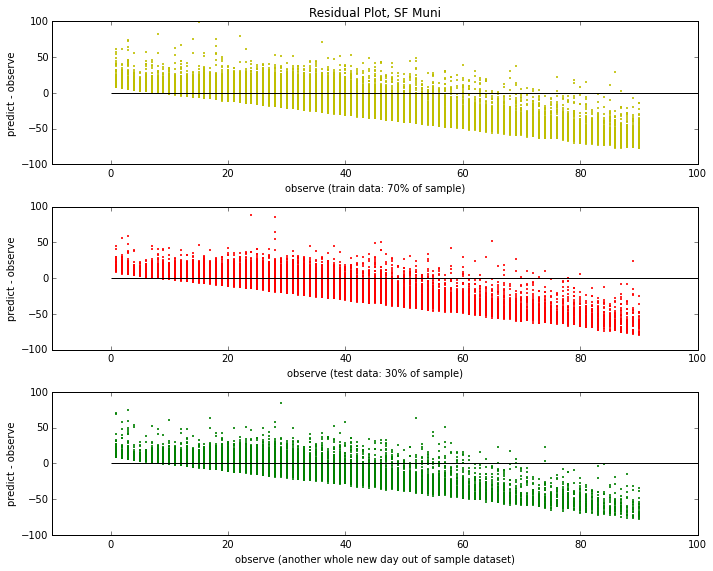

In [58]:
plt.figure(1)
plt.subplot(311)
plt.scatter(y2_train, lm2.predict(X2_train) - y2_train, c='y', s=1,edgecolor='y')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-10, 100, -100, 100])
plt.title('Residual Plot, SF Muni')
plt.ylabel('predict - observe')
plt.xlabel('observe (train data: 70% of sample)')

plt.subplot(312)
plt.scatter(y2_test, lm2.predict(X2_test) - y2_test, c='r', s=1,edgecolor='r')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-10, 100, -100, 100])
plt.ylabel('predict - observe')
plt.xlabel('observe (test data: 30% of sample)')

plt.subplot(313)
plt.scatter(y3_test, lm2.predict(X3_test) - y3_test, c='g', s=1,edgecolor='g')

plt.tight_layout()
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-10, 100, -100, 100])
plt.ylabel('predict - observe')
plt.xlabel('observe (another whole new day out of sample dataset)')

plt.tight_layout()
plt.figure(figsize=(10,5))
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
plt.show()

z: 269.508703903
sort data: 0.00528624281969


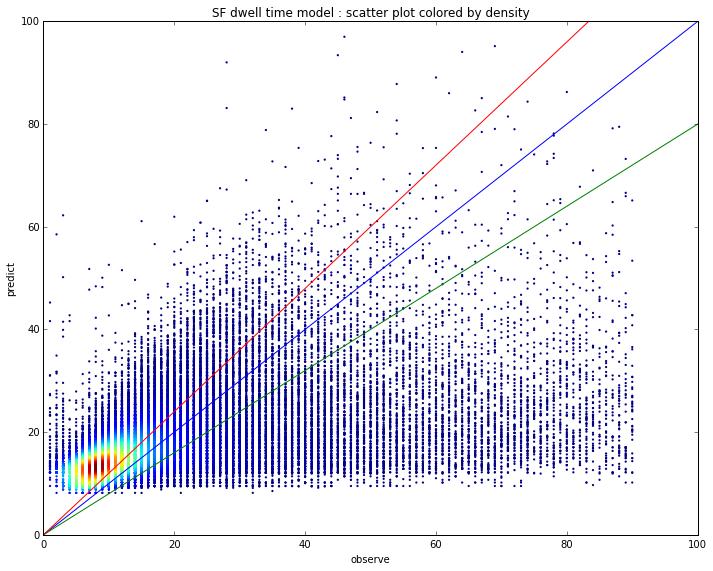

In [45]:
x2 = y2_test
y2 = lm2.predict(X2_test)

# Calculate the point density
start = timeit.default_timer()
xy2 = np.vstack([x2,y2])
z2 = gaussian_kde(xy2)(xy2)
stop = timeit.default_timer()
print 'z:', stop - start

# Sort the points by density, so that the densest points are plotted last
start = timeit.default_timer()
idx = z2.argsort()
stop = timeit.default_timer()
print 'sort data:', stop - start

x2, y2, z2 = x2[idx], y2[idx], z2[idx]
fig, ax = plt.subplots()
ax.scatter(x2, y2, c=z2, s=5, edgecolor='')

x2 = np.linspace(*ax.get_xlim()) 
ax.plot(x2, x2) 
ax.plot(x2, 0.8*x2)
ax.plot(x2, 1.2*x2)


plt.axis([0, 100, 0, 100])
plt.title('SF dwell time model : scatter plot colored by density')
plt.ylabel('predict')
plt.xlabel('observe')

plt.tight_layout()
plt.figure(figsize=(10,5))
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
plt.show()


# Trend line plot

In [61]:
df_test['on+off'] = df_test['ON'] + df_test['OFF']
X3_test = df_test[['ON','OFF','on+off', 'Floor','three_doors',
                   'Express','OWL','Rapid','on_threedoors','off_threedoors',
                   'on_floor','off_floor','on_express','off_express',
                   'on_rapid','off_rapid','on_owl','off_owl', 'friction']]

In [62]:
df_est = []
df_est = pd.DataFrame(lm3.predict(X3_test), index = X3_test.index, columns = ['Dwell_Time_Esti'])
test = pd.concat([X3_test, df_est], axis=1, join='inner')
test.head()

,ON,OFF,on+off,Floor,three_doors,Express,OWL,Rapid,on_threedoors,off_threedoors,on_floor,off_floor,on_express,off_express,on_rapid,off_rapid,on_owl,off_owl,friction,Dwell_Time_Esti
19,1,1,2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,14.562
37,1,0,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,12.918
56,1,0,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,12.918
59,3,2,5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,20.932
61,5,0,5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,22.367


In [63]:
test_artic = test[test.three_doors == 1]
test_std = test[test.three_doors == 0]
test_low = test[test.Floor == 1]
test_exp = test[test.Express == 1]
test_rapid = test[test.Rapid == 1]
test_owl = test[test.OWL == 1]
test_local = test[(test.Express != 1) & (test.OWL != 1) & (test.Rapid != 1)]

19996 19996


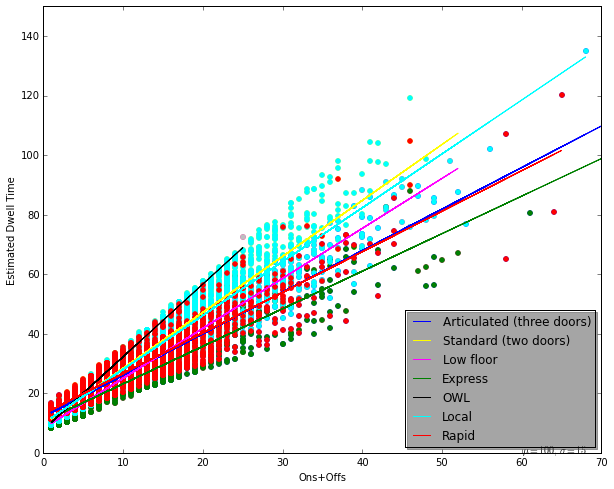

In [65]:
fig, ax = plt.subplots()

# Articulated bus
x1 = test_artic['on+off']
y1 = test_artic['Dwell_Time_Esti']
print len(x1), len(y1)
# plot the data itself
ax.scatter(x1, y1, color = 'blue')
#plot the trend line
fit = np.polyfit(x1, y1, deg=1)
ax.plot(x1, fit[0] * x1 + fit[1], color='blue', label='Articulated (three doors)')

#Standard bus
x2 = test_std['on+off']
y2 = test_std['Dwell_Time_Esti']
ax.scatter(x2, y2, color = 'yellow')
fit = np.polyfit(x2, y2, deg=1)
ax.plot(x2, fit[0] * x2 + fit[1], color='yellow', label='Standard (two doors)')

#Low floor
x7 = test_low['on+off']
y7 = test_low['Dwell_Time_Esti']
ax.scatter(x7, y7, color = 'magenta')
fit = np.polyfit(x7, y7, deg=1)
ax.plot(x7, fit[0] * x7 + fit[1], color='magenta', label= 'Low floor')

#Express
x4 = test_exp['on+off']
y4 = test_exp['Dwell_Time_Esti']
ax.scatter(x4, y4, color = 'green')
fit = np.polyfit(x4, y4, deg=1)
ax.plot(x4, fit[0] * x4 + fit[1], color='green', label= 'Express')

#OWL
x5 = test_owl['on+off']
y5 = test_owl['Dwell_Time_Esti']
ax.scatter(x5, y5, color = '0.75')
fit = np.polyfit(x5, y5, deg=1)
ax.plot(x5, fit[0] * x5 + fit[1], color='black', label= 'OWL')

#Local
x6 = test_local['on+off']
y6 = test_local['Dwell_Time_Esti']
ax.scatter(x6, y6, color = 'cyan')
fit = np.polyfit(x6, y6, deg=1)
ax.plot(x6, fit[0] * x6 + fit[1], color='cyan', label= 'Local')

#Rapid
x8 = test_rapid['on+off']
y8 = test_rapid['Dwell_Time_Esti']
ax.scatter(x8, y8, color = 'red')
fit = np.polyfit(x8, y8, deg=1)
ax.plot(x8, fit[0] * x8 + fit[1], color='red', label= 'Rapid')

plt.xlabel('Ons+Offs')
plt.ylabel('Estimated Dwell Time')
plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
ax.legend(loc='lower right', shadow=True)
#plt.figure(figsize=(10,5))
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
plt.axis([0, 70, 0, 150])

fig.show()

#three doors trend is exactly as same as rapid ride bus... 

In [57]:
print 'end'

end
